In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

tcmalloc: large alloc 1073750016 bytes == 0x58718000 @  0x7f7854f242a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [0]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd 


import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.datasets
import torch.nn.functional as F
import torch
from torch.autograd import Variable

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:
from google.colab import drive

MOUNT_PATH = "/content/gdrive"
drive.mount(MOUNT_PATH)

DATA_PATH = MOUNT_PATH + "/My Drive/Kaggle/data"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
DATA_PATH = MOUNT_PATH + "/My Drive/Kaggle/data"

train_images = np.load(DATA_PATH + '/train_images.npy', encoding='latin1')
print("Train data shape : ", train_images.shape)

train_labels = np.genfromtxt(DATA_PATH + '/train_labels.csv', names=True, delimiter=',', dtype=[('Id', 'i8'), ('Category', 'S5')])
print("Train labels shape : ", train_labels.shape)

test_images = np.load(DATA_PATH + '/test_images.npy', encoding='latin1')
print("Test data shape : ", test_images.shape)

Train data shape :  (10000, 2)
Train labels shape :  (10000,)
Test data shape :  (10000, 2)


In [0]:
def extract_column(array, index=1):
  return np.array([array[i][index] for i in range(len(array))])

In [0]:
def split_data(X,y,test_percentage = 25,validation = False):

  split_index = (100 - test_percentage) * len(X) // 100

  X_train, X_test = X[:split_index], X[split_index:]
  y_train, y_test = y[:split_index], y[split_index:]
  
  if(not validation):
    return (X_train, y_train), (X_test, y_test)
  else:
    
    split_index = (100 - test_percentage) * len(X_train) // 100
    
    X_train, X_valid = X_train[:split_index], X_train[split_index:]
    y_train, y_valid = y_train[:split_index], y_train[split_index:]
    
    return (X_train, y_train), (X_test, y_test), (X_valid, y_valid)

In [0]:
X = extract_column(train_images, 1)
X.shape

(10000, 10000)

In [0]:
T = extract_column(test_images, 1)
T.shape

(10000, 10000)

In [0]:
labels = extract_column(train_labels, 1)
labels.shape

(10000,)

In [0]:
category_bytes = np.unique(labels)

print("Original category labels : ",category_bytes)
    
categories = {}

for i in range(len(category_bytes)):
    categories[category_bytes[i]] = i  
    
print("\n\nIntegerized labels : ",categories.values())

Original category labels :  [b'apple' b'empty' b'moust' b'mouth' b'mug' b'nail' b'nose' b'octag'
 b'paint' b'panda' b'parro' b'peanu' b'pear' b'penci' b'pengu' b'pillo'
 b'pinea' b'pool' b'rabbi' b'rhino' b'rifle' b'rolle' b'sailb' b'scorp'
 b'screw' b'shove' b'sink' b'skate' b'skull' b'spoon' b'squig']


Integerized labels :  dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])


In [0]:
original_labels =  ['apple', 'empty', 'moustache', 'mouth', 'mug', 'nail', 'nose', 'octagon', 'paintbrush', 'panda', 'parrot', 'peanut', 'pear', 'pencil','penguin', 'pillow', 'pineapple', 'pool', 'rabbit', 'rhinoceros', 'rifle', 'rollerskates', 'sailboat', 'scorpion', 'screwdriver', 'shovel', 'sink', 'skateboard', 'skull', 'spoon', 'squiggle']

In [0]:
y = np.array([ categories[label] for label in labels]) 

In [0]:
print("X.shape = ",X.shape)
print("y.shape = ",y.shape)

print("\n\nT.shape = ",T.shape)

X.shape =  (10000, 10000)
y.shape =  (10000,)


T.shape =  (10000, 10000)


In [0]:
(X_train, y_train), (X_test, y_test) = split_data(X,y)

In [0]:
D = X.reshape((10000, 1, 100, 100))
D.shape

(10000, 1, 100, 100)

In [0]:
def reshape_for_CNN(array):
  return array.reshape((array.shape[0], 1, 100, 100))

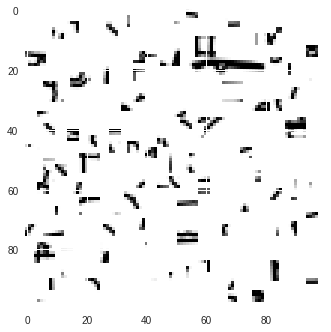

In [0]:
WW = reshape_for_CNN((X_train))
plt.imshow(WW[1][0])

In [0]:
def denoise_images(array):
  images = []
  for image in array:
    images.append(denoise(image[0], weight=210))
    
  print(np.array(images).shape)  
  return np.array(images).reshape(array.shape)

In [0]:
XX = denoise_images(WW[:100])
XX.shape

(100, 100, 100)


(100, 1, 100, 100)

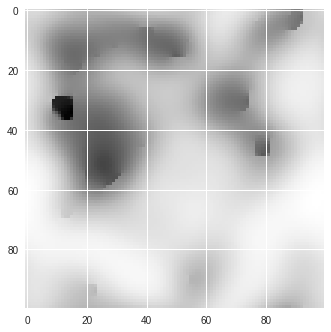

In [0]:
plt.imshow(XX[0][0])

def normalize_images(X):


In [0]:
def normalize_images(X):
  return np.array([x/255.0 for x in X])

In [0]:
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0,), (257,))])
transform = transforms.Compose([transforms.RandomHorizontalFlip()])

In [0]:
class DrawingsDataset(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).float()
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
        
        return x, y
    
    def __len__(self):
        return len(self.data)

In [0]:
num_classes = 31

In [0]:
def get_default_hyperparams():
  num_epochs = 6
  batch_size = 100
  learning_rate = 0.001
  
  return num_epochs, batch_size, learning_rate  

In [0]:

reshape_for_CNN(X_train)

In [0]:
train_set = DrawingsDataset(reshape_for_CNN(normalize_images(X_train)), y_train)#, transform)

test_set = DrawingsDataset(reshape_for_CNN(normalize_images(X_test)), y_test) #, transform)

train_loader = DataLoader(
    train_set,
    batch_size=100,
    shuffle=True,
    num_workers=2,
    pin_memory=torch.cuda.is_available()
)

test_loader = DataLoader(
    test_set,
    batch_size=1,
    shuffle=False,
    num_workers=2,
    pin_memory=torch.cuda.is_available()
)

In [0]:
final_train_set = DrawingsDataset(reshape_for_CNN(normalize_images(X)), y)

final_train_loader = DataLoader(
    final_train_set,
    batch_size=100,
    shuffle=True,
    num_workers=2,
    pin_memory=torch.cuda.is_available()
)

final_test_set = DrawingsDataset(reshape_for_CNN(normalize_images(T)), y)

final_test_loader = DataLoader(
    final_test_set,
    batch_size=1,
    shuffle=False,
    num_workers=2,
    pin_memory=torch.cuda.is_available()
)

In [0]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
#             nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc1 = nn.Linear(50 * 50 * 32, 31)
        
    def forward(self, x):
        out = self.layer1(x)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        return out

In [0]:
class SimpleCNN_Dropout(nn.Module):
    def __init__(self):
        super(SimpleCNN_Dropout, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
#             nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout(0.4)
        self.fc1 = nn.Linear(50 * 50 * 32, 31)
        
    def forward(self, x):
        out = self.layer1(x)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        return out

In [0]:
class SimpleCNN_BatchNorm(nn.Module):
    def __init__(self):
        super(SimpleCNN_BatchNorm, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc1 = nn.Linear(50 * 50 * 32, 31)
        
    def forward(self, x):
        out = self.layer1(x)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        return out

In [0]:
class SimpleCNN_BatchNorm_Dropout(nn.Module):
    def __init__(self):
        super(SimpleCNN_BatchNorm_Dropout, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout(0.4)
        self.fc1 = nn.Linear(50 * 50 * 32, 31)
        
    def forward(self, x):
        out = self.layer1(x)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        return out

In [0]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
#             nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
#             nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(25 * 25 * 64, 961)
        self.fc2 = nn.Linear(961, 31)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [0]:
class Single_FC_CNN(nn.Module):
    def __init__(self):
        super(Single_FC_CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(25 * 25 * 64, 31)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        return out

In [0]:
class Single_Softmax_CNN(nn.Module):
    def __init__(self):
        super(Single_Softmax_CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(25 * 25 * 64, 31)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = F.softmax(self.fc1(out))
        return out

In [0]:
class CNN_BN(nn.Module):
    def __init__(self):
        super(CNN_BN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(25 * 25 * 64, 961)
        self.fc2 = nn.Linear(961, 31)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [0]:
class Bigger_CNN(nn.Module):
    def __init__(self):
        super(Bigger_CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout(0.2)
        self.fc1 = nn.Linear(12 * 12 * 128, 961)
        self.fc2 = nn.Linear(961, 31)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [0]:
class Bigger_CNN_Plus(nn.Module):
    def __init__(self):
        super(Bigger_CNN_Plus, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout(0.2)
        self.fc1 = nn.Linear(12 * 12 * 128, 12 * 128)
        self.fc2 = nn.Linear(12 * 128, 6 * 128)
        self.fc3 = nn.Linear(6 * 128, 31)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

In [0]:
MODEL_STORE_PATH = MOUNT_PATH + "/My Drive/Kaggle/models/"

In [0]:
def train_cnn(cnn, criterion, optimizer, data_loader = train_loader, batch_size = 100, num_epochs = 6, learning_rate = 0.001):
  total_step = len(train_loader)
  loss_list = []
  acc_list = []
  for epoch in range(num_epochs):
      for i, (images, labels) in enumerate(data_loader):
        
#           images, labels = images.type(torch.FloatTensor).to(device), labels.type(torch.LongTensor).to(device)
          images = Variable(images.cuda())
          labels = Variable(labels.cuda())

        
          # Run the forward pass
          outputs = cnn(images)
          loss = criterion(outputs, labels)
          loss_list.append(loss.item())

          # Backprop and perform Adam optimisation
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          # Track the accuracy
          total = labels.size(0)
          _, predicted = torch.max(outputs.data, 1)
          correct = (predicted == labels).sum().item()
          acc_list.append(correct / total)

          if (i + 1) == total_step:
              print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),(correct / total) * 100))
              test_cnn("", cnn)
                         
  return cnn


In [0]:
def test_cnn(description, cnn, data_loader = test_loader):
  # Test the model
  cnn.eval()
  result = []
  with torch.no_grad():
      correct = 0
      total = 0
      for images, labels in data_loader:
        
#           images, labels = images.type(torch.FloatTensor).to(device), labels.type(torch.LongTensor).to(device)

          images = Variable(images.cuda())
          labels = Variable(labels.cuda())

          outputs = cnn(images)
          _, predicted = torch.max(outputs.data, 1)
          result.append(predicted)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

      print('Test Accuracy of the model on the test images: {} %'.format((correct / total) * 100))

  # Save the model and plot
  
  if description != "":
    torch.save(cnn.state_dict(), MODEL_STORE_PATH + 'cnn_model_{}.ckpt'.format(description))

  final = np.array(([ value.cpu().numpy() for value in result]))
  
  return final.T

In [0]:
def run_experiment(description, cnn, num_epochs = 6, learning_rate = 0.001, batch_size = 100):
  cnn = cnn.cuda()
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)
  
  cnn = train_cnn(cnn, criterion, optimizer, batch_size = 100, num_epochs = num_epochs, learning_rate = learning_rate)
  p = test_cnn(description, cnn)
  return p, cnn

In [0]:
# Original CNN network with initial params
po, co = run_experiment("", CNN())

Epoch [1/6], Step [75/75], Loss: 3.4094, Accuracy: 2.00%
Epoch [2/6], Step [75/75], Loss: 3.3543, Accuracy: 6.00%
Epoch [3/6], Step [75/75], Loss: 3.4110, Accuracy: 7.00%
Epoch [4/6], Step [75/75], Loss: 3.3506, Accuracy: 6.00%
Epoch [5/6], Step [75/75], Loss: 3.3612, Accuracy: 3.00%
Epoch [6/6], Step [75/75], Loss: 3.3617, Accuracy: 5.00%
Test Accuracy of the model on the test images: 6.16 %


In [0]:
# Modifying learning rate to 0.0001 from 0.001
run_experiment("with_lr_0001", CNN(), learning_rate = 0.0001)

Epoch [1/6], Step [75/75], Loss: 3.3509, Accuracy: 8.00%
Epoch [2/6], Step [75/75], Loss: 3.3126, Accuracy: 7.00%
Epoch [3/6], Step [75/75], Loss: 3.0986, Accuracy: 11.00%
Epoch [4/6], Step [75/75], Loss: 2.6637, Accuracy: 28.00%
Epoch [5/6], Step [75/75], Loss: 2.3986, Accuracy: 38.00%
Epoch [6/6], Step [75/75], Loss: 1.8036, Accuracy: 52.00%
Test Accuracy of the model on the test images: 5.800000000000001 %


In [0]:
# Modifying num_epochs to 10
run_experiment("with_num_epochs_10", CNN(), num_epochs = 10)

Epoch [1/6], Step [75/75], Loss: 3.4119, Accuracy: 6.00%
Epoch [2/6], Step [75/75], Loss: 3.3479, Accuracy: 4.00%
Epoch [3/6], Step [75/75], Loss: 3.3362, Accuracy: 7.00%
Epoch [4/6], Step [75/75], Loss: 3.4327, Accuracy: 5.00%
Epoch [5/6], Step [75/75], Loss: 3.3525, Accuracy: 5.00%
Epoch [6/6], Step [75/75], Loss: 3.3955, Accuracy: 5.00%
Test Accuracy of the model on the test images: 6.16 %


In [0]:
# Modifying network to 1 fc
run_experiment("1_fc", Single_FC_CNN())

Epoch [1/6], Step [75/75], Loss: 3.3987, Accuracy: 3.00%
Epoch [2/6], Step [75/75], Loss: 3.3538, Accuracy: 4.00%
Epoch [3/6], Step [75/75], Loss: 3.3429, Accuracy: 6.00%
Epoch [4/6], Step [75/75], Loss: 3.2561, Accuracy: 11.00%
Epoch [5/6], Step [75/75], Loss: 3.0956, Accuracy: 10.00%
Epoch [6/6], Step [75/75], Loss: 3.0490, Accuracy: 14.00%
Test Accuracy of the model on the test images: 4.72 %


In [0]:
# Modifying network to have softmax activation
run_experiment("softmax", Single_Softmax_CNN())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch [1/6], Step [75/75], Loss: 3.4303, Accuracy: 4.00%
Epoch [2/6], Step [75/75], Loss: 3.4291, Accuracy: 3.00%
Epoch [3/6], Step [75/75], Loss: 3.4243, Accuracy: 5.00%
Epoch [4/6], Step [75/75], Loss: 3.4104, Accuracy: 7.00%
Epoch [5/6], Step [75/75], Loss: 3.4125, Accuracy: 6.00%
Epoch [6/6], Step [75/75], Loss: 3.3950, Accuracy: 9.00%
Test Accuracy of the model on the test images: 5.92 %


In [0]:
# Modifying network to have softmax activation and 4 epochs
num_epochs = 4
run_experiment("softmax_4epochs", Single_Softmax_CNN(), num_epochs = 4)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch [1/6], Step [75/75], Loss: 3.4479, Accuracy: 4.00%
Epoch [2/6], Step [75/75], Loss: 3.4379, Accuracy: 5.00%
Epoch [3/6], Step [75/75], Loss: 3.4279, Accuracy: 6.00%
Epoch [4/6], Step [75/75], Loss: 3.4479, Accuracy: 4.00%
Epoch [5/6], Step [75/75], Loss: 3.4779, Accuracy: 1.00%
Epoch [6/6], Step [75/75], Loss: 3.4179, Accuracy: 7.00%
Test Accuracy of the model on the test images: 5.0 %


In [0]:
# Modifying network to have batch norm and horizontal augmentation
run_experiment("cnn_batch_norm", CNN_BN())

Epoch [1/6], Step [75/75], Loss: 6.0397, Accuracy: 2.00%
Epoch [2/6], Step [75/75], Loss: 4.3918, Accuracy: 7.00%
Epoch [3/6], Step [75/75], Loss: 4.8331, Accuracy: 11.00%
Epoch [4/6], Step [75/75], Loss: 3.9629, Accuracy: 13.00%
Epoch [5/6], Step [75/75], Loss: 4.2980, Accuracy: 10.00%
Epoch [6/6], Step [75/75], Loss: 3.7374, Accuracy: 16.00%
Test Accuracy of the model on the test images: 5.56 %


In [0]:
# Modifying network to have batch norm and horizontal augmentation
run_experiment("cnn_linear_batch_norm_4epochs", CNN_BN(), num_epochs = 4)

Epoch [1/6], Step [75/75], Loss: 6.7775, Accuracy: 3.00%
Epoch [2/6], Step [75/75], Loss: 3.9308, Accuracy: 3.00%
Epoch [3/6], Step [75/75], Loss: 4.1918, Accuracy: 8.00%
Epoch [4/6], Step [75/75], Loss: 4.1616, Accuracy: 9.00%
Epoch [5/6], Step [75/75], Loss: 4.2893, Accuracy: 7.00%
Epoch [6/6], Step [75/75], Loss: 3.8575, Accuracy: 12.00%
Test Accuracy of the model on the test images: 4.52 %


In [0]:
# Modifying network to have batch norm and horizontal augmentation
run_experiment("bigger_CNN", Bigger_CNN(), num_epochs=10)

Epoch [1/6], Step [75/75], Loss: 3.3698, Accuracy: 3.00%
Epoch [2/6], Step [75/75], Loss: 3.3973, Accuracy: 5.00%
Epoch [3/6], Step [75/75], Loss: 3.3622, Accuracy: 7.00%
Epoch [4/6], Step [75/75], Loss: 3.3937, Accuracy: 2.00%
Epoch [5/6], Step [75/75], Loss: 3.3711, Accuracy: 2.00%
Epoch [6/6], Step [75/75], Loss: 3.3507, Accuracy: 5.00%
Test Accuracy of the model on the test images: 6.16 %


In [0]:
def run_final_experiment(description, cnn, num_epochs = 6, learning_rate = 0.001, batch_size = 100):
  cnn = cnn.cuda()
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)
  
  cnn = train_cnn(cnn, criterion, optimizer, final_train_loader, batch_size = 100, num_epochs = num_epochs, learning_rate = learning_rate)
  p = test_cnn(description, cnn, final_test_loader)
  return p, cnn

In [0]:
prediction = run_final_experiment("final_run_cnn", CNN())

Epoch [1/6], Step [75/75], Loss: 3.4176, Accuracy: 4.00%
Epoch [2/6], Step [75/75], Loss: 3.4041, Accuracy: 5.00%
Epoch [3/6], Step [75/75], Loss: 3.4080, Accuracy: 4.00%
Epoch [4/6], Step [75/75], Loss: 3.3728, Accuracy: 8.00%
Epoch [5/6], Step [75/75], Loss: 3.3566, Accuracy: 5.00%
Epoch [6/6], Step [75/75], Loss: 3.4356, Accuracy: 5.00%
tensor([3], device='cuda:0')
tensor([3], device='cuda:0')
tensor([3], device='cuda:0')
tensor([3], device='cuda:0')
tensor([3], device='cuda:0')
tensor([3], device='cuda:0')
tensor([3], device='cuda:0')
tensor([3], device='cuda:0')
tensor([3], device='cuda:0')
tensor([3], device='cuda:0')
tensor([3], device='cuda:0')
tensor([3], device='cuda:0')
tensor([3], device='cuda:0')
tensor([3], device='cuda:0')
tensor([3], device='cuda:0')
tensor([3], device='cuda:0')
tensor([3], device='cuda:0')
tensor([3], device='cuda:0')
tensor([3], device='cuda:0')
tensor([3], device='cuda:0')
tensor([3], device='cuda:0')
tensor([3], device='cuda:0')
tensor([3], device='

In [0]:
prediction[1099][0]

tensor(3, device='cuda:0')

In [0]:
y

array([25, 20, 23, ..., 21,  3, 13])

In [0]:
pred = np.ones(len(y),) * 10

In [0]:
np.sum(pred==y) / len(y)

0.0206

In [0]:
#Simple CNN
p1, m1 = run_experiment("simple_cnn", SimpleCNN())

Epoch [1/6], Step [75/75], Loss: 3.4742, Accuracy: 5.00%
Epoch [2/6], Step [75/75], Loss: 2.9623, Accuracy: 26.00%
Epoch [3/6], Step [75/75], Loss: 1.7481, Accuracy: 53.00%
Epoch [4/6], Step [75/75], Loss: 0.1841, Accuracy: 97.00%
Epoch [5/6], Step [75/75], Loss: 0.0337, Accuracy: 100.00%
Epoch [6/6], Step [75/75], Loss: 0.0185, Accuracy: 100.00%
Test Accuracy of the model on the test images: 5.24 %


In [0]:
m1

SimpleCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=80000, out_features=31, bias=True)
)

In [0]:
def denoise(img, weight=0.1, eps=1e-3, num_iter_max=200):
  
  u = np.zeros_like(img)
  px = np.zeros_like(img)
  py = np.zeros_like(img)
 
  nm = np.prod(img.shape[:2])
  tau = 0.125
 
  i = 0

  while i < num_iter_max:
    u_old = u
        
    # x and y components of u's gradient
    ux = np.roll(u, -1, axis=1) - u
    uy = np.roll(u, -1, axis=0) - u
    
    # update the dual variable
    px_new = px + (tau / weight) * ux
    py_new = py + (tau / weight) * uy
    
    norm_new = np.maximum(1, np.sqrt(px_new **2 + py_new ** 2))
    px = px_new / norm_new
    py = py_new / norm_new
    
    # calculate divergence
    rx = np.roll(px, 1, axis=1)
    ry = np.roll(py, 1, axis=0)
    div_p = (px - rx) + (py - ry)
 
    # update image
    u = img + weight * div_p
    
    # calculate error
    error = np.linalg.norm(u - u_old) / np.sqrt(nm)
    
    if i == 0:
        err_init = error
        err_prev = error
    else:
        # break if error small enough
        if np.abs(err_prev - error) < eps * err_init:
            break
        else:
            e_prev = error
             
    # don't forget to update iterator
    i += 1
 
  return u

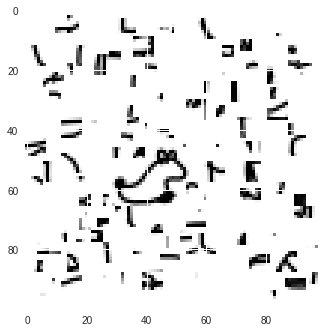

In [0]:

plt.imshow(X[111].reshape(100,100))

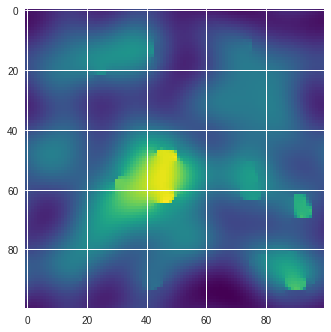

In [0]:
plt.imshow(denoise(X[111].reshape(100,100), weight=250), cmap='viridis')

In [0]:
original_labels[y[111]]

'rabbit'

In [0]:
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)
from skimage import data, img_as_float
from skimage.util import random_noise

from scipy import ndimage

In [0]:
sigma_est = estimate_sigma(X[0].reshape(100,100), multichannel=False, average_sigmas=True)
sigma_est

19.798450902500306

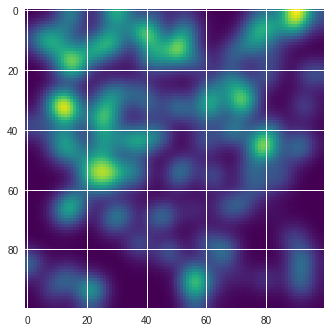

In [0]:
plt.imshow(ndimage.gaussian_filter(X[0].reshape(100,100), 3.5), cmap='viridis')

In [0]:
#Simple CNN
p1, m1 = run_experiment("simple_cnn10epochs", SimpleCNN(), num_epochs = 50)

Epoch [1/50], Step [75/75], Loss: 3.5654, Accuracy: 2.00%
Epoch [2/50], Step [75/75], Loss: 2.7520, Accuracy: 22.00%
Epoch [3/50], Step [75/75], Loss: 1.7593, Accuracy: 54.00%
Epoch [4/50], Step [75/75], Loss: 0.4121, Accuracy: 92.00%
Epoch [5/50], Step [75/75], Loss: 0.0745, Accuracy: 100.00%
Epoch [6/50], Step [75/75], Loss: 0.0240, Accuracy: 100.00%
Epoch [7/50], Step [75/75], Loss: 0.0158, Accuracy: 100.00%
Epoch [8/50], Step [75/75], Loss: 0.0115, Accuracy: 100.00%
Epoch [9/50], Step [75/75], Loss: 0.0093, Accuracy: 100.00%
Epoch [10/50], Step [75/75], Loss: 0.0070, Accuracy: 100.00%
Epoch [11/50], Step [75/75], Loss: 0.0063, Accuracy: 100.00%
Epoch [12/50], Step [75/75], Loss: 0.0046, Accuracy: 100.00%
Epoch [13/50], Step [75/75], Loss: 0.0040, Accuracy: 100.00%
Epoch [14/50], Step [75/75], Loss: 0.0036, Accuracy: 100.00%
Epoch [15/50], Step [75/75], Loss: 0.0033, Accuracy: 100.00%
Epoch [16/50], Step [75/75], Loss: 0.0028, Accuracy: 100.00%
Epoch [17/50], Step [75/75], Loss: 0.0

In [0]:
#Simple CNN
p1, m1 = run_experiment("simple_cnn_10epochs", SimpleCNN(), num_epochs = 10)

Epoch [1/10], Step [75/75], Loss: 3.5284, Accuracy: 5.00%
Epoch [2/10], Step [75/75], Loss: 2.8063, Accuracy: 26.00%
Epoch [3/10], Step [75/75], Loss: 1.9441, Accuracy: 46.00%
Epoch [4/10], Step [75/75], Loss: 0.7402, Accuracy: 84.00%
Epoch [5/10], Step [75/75], Loss: 0.1469, Accuracy: 100.00%
Epoch [6/10], Step [75/75], Loss: 0.0615, Accuracy: 100.00%
Epoch [7/10], Step [75/75], Loss: 0.0234, Accuracy: 100.00%
Epoch [8/10], Step [75/75], Loss: 0.0186, Accuracy: 100.00%
Epoch [9/10], Step [75/75], Loss: 0.0128, Accuracy: 100.00%
Epoch [10/10], Step [75/75], Loss: 0.0108, Accuracy: 100.00%
Test Accuracy of the model on the test images: 4.72 %
[array([2]), array([3]), array([28]), array([26]), array([16]), array([15]), array([3]), array([16]), array([1]), array([15]), array([1]), array([27]), array([25]), array([16]), array([28]), array([28]), array([5]), array([0]), array([22]), array([17]), array([4]), array([27]), array([6]), array([7]), array([14]), array([20]), array([15]), array([2

In [0]:
# Modifying learning rate to 0.0001 from 0.001
p00, _ = run_experiment("with_lr_00001", CNN(), learning_rate = 0.00001, num_epochs = 200)

Epoch [1/200], Step [75/75], Loss: 3.3646, Accuracy: 5.00%
Epoch [2/200], Step [75/75], Loss: 3.3798, Accuracy: 8.00%
Epoch [3/200], Step [75/75], Loss: 3.3259, Accuracy: 10.00%
Epoch [4/200], Step [75/75], Loss: 3.3341, Accuracy: 6.00%
Epoch [5/200], Step [75/75], Loss: 3.3171, Accuracy: 5.00%
Epoch [6/200], Step [75/75], Loss: 3.2651, Accuracy: 9.00%
Epoch [7/200], Step [75/75], Loss: 3.2293, Accuracy: 18.00%
Epoch [8/200], Step [75/75], Loss: 3.2896, Accuracy: 6.00%
Epoch [9/200], Step [75/75], Loss: 3.0934, Accuracy: 15.00%
Epoch [10/200], Step [75/75], Loss: 3.0794, Accuracy: 17.00%
Epoch [11/200], Step [75/75], Loss: 2.9713, Accuracy: 19.00%
Epoch [12/200], Step [75/75], Loss: 2.9714, Accuracy: 13.00%
Epoch [13/200], Step [75/75], Loss: 2.8951, Accuracy: 18.00%
Epoch [14/200], Step [75/75], Loss: 2.8960, Accuracy: 20.00%
Epoch [15/200], Step [75/75], Loss: 2.8678, Accuracy: 18.00%
Epoch [16/200], Step [75/75], Loss: 2.8723, Accuracy: 15.00%
Epoch [17/200], Step [75/75], Loss: 2.6

In [0]:
p00

array([[22,  3, 28, ..., 27, 20, 27]])

In [0]:
#Denoised Simple CNN
p1111, m11111 = run_experiment("denoised_simple_cnn_10epochs", SimpleCNN(), num_epochs = 10)

Epoch [1/10], Step [75/75], Loss: 3.3465, Accuracy: 9.00%
Epoch [2/10], Step [75/75], Loss: 3.1888, Accuracy: 6.00%
Epoch [3/10], Step [75/75], Loss: 3.0567, Accuracy: 14.00%
Epoch [4/10], Step [75/75], Loss: 3.0116, Accuracy: 11.00%
Epoch [5/10], Step [75/75], Loss: 2.9777, Accuracy: 23.00%
Epoch [6/10], Step [75/75], Loss: 3.1027, Accuracy: 12.00%
Epoch [7/10], Step [75/75], Loss: 3.0381, Accuracy: 13.00%
Epoch [8/10], Step [75/75], Loss: 2.8864, Accuracy: 17.00%
Epoch [9/10], Step [75/75], Loss: 2.7864, Accuracy: 24.00%
Epoch [10/10], Step [75/75], Loss: 2.6642, Accuracy: 23.00%
Test Accuracy of the model on the test images: 7.68 %


In [0]:
#Denoised Simple CNN
p1111, m11111 = run_experiment("denoised_simple_cnn_50epochs", SimpleCNN(), num_epochs = 50)

Epoch [1/50], Step [75/75], Loss: 3.3167, Accuracy: 8.00%
Epoch [2/50], Step [75/75], Loss: 3.2426, Accuracy: 7.00%
Epoch [3/50], Step [75/75], Loss: 3.1568, Accuracy: 13.00%
Epoch [4/50], Step [75/75], Loss: 3.0609, Accuracy: 16.00%
Epoch [5/50], Step [75/75], Loss: 3.0666, Accuracy: 15.00%
Epoch [6/50], Step [75/75], Loss: 2.9828, Accuracy: 11.00%
Epoch [7/50], Step [75/75], Loss: 3.1095, Accuracy: 8.00%
Epoch [8/50], Step [75/75], Loss: 3.1129, Accuracy: 15.00%
Epoch [9/50], Step [75/75], Loss: 2.8435, Accuracy: 15.00%
Epoch [10/50], Step [75/75], Loss: 3.0840, Accuracy: 11.00%
Epoch [11/50], Step [75/75], Loss: 3.0053, Accuracy: 15.00%
Epoch [12/50], Step [75/75], Loss: 2.7949, Accuracy: 26.00%
Epoch [13/50], Step [75/75], Loss: 3.0179, Accuracy: 12.00%
Epoch [14/50], Step [75/75], Loss: 2.8847, Accuracy: 13.00%
Epoch [15/50], Step [75/75], Loss: 2.8813, Accuracy: 20.00%
Epoch [16/50], Step [75/75], Loss: 2.7833, Accuracy: 22.00%
Epoch [17/50], Step [75/75], Loss: 2.7772, Accuracy:

In [0]:
#Denoised Simple CNN
p22222, m22222 = run_experiment("denoised_simple_cnn_50epochs_lr1", SimpleCNN(), num_epochs = 100, learning_rate = 0.00001)

Epoch [1/100], Step [75/75], Loss: 3.3003, Accuracy: 8.00%
Epoch [2/100], Step [75/75], Loss: 3.3843, Accuracy: 4.00%
Epoch [3/100], Step [75/75], Loss: 3.3616, Accuracy: 8.00%
Epoch [4/100], Step [75/75], Loss: 3.3194, Accuracy: 8.00%
Epoch [5/100], Step [75/75], Loss: 3.3696, Accuracy: 1.00%
Epoch [6/100], Step [75/75], Loss: 3.4345, Accuracy: 4.00%
Epoch [7/100], Step [75/75], Loss: 3.3844, Accuracy: 5.00%
Epoch [8/100], Step [75/75], Loss: 3.3185, Accuracy: 9.00%
Epoch [9/100], Step [75/75], Loss: 3.4328, Accuracy: 3.00%
Epoch [10/100], Step [75/75], Loss: 3.3180, Accuracy: 11.00%
Epoch [11/100], Step [75/75], Loss: 3.3474, Accuracy: 4.00%
Epoch [12/100], Step [75/75], Loss: 3.3440, Accuracy: 4.00%
Epoch [13/100], Step [75/75], Loss: 3.3854, Accuracy: 9.00%
Epoch [14/100], Step [75/75], Loss: 3.2380, Accuracy: 7.00%
Epoch [15/100], Step [75/75], Loss: 3.3536, Accuracy: 9.00%
Epoch [16/100], Step [75/75], Loss: 3.2802, Accuracy: 6.00%
Epoch [17/100], Step [75/75], Loss: 3.2922, Accu

In [0]:
# Modifying learning rate to 0.0001 from 0.001
p00, _ = run_experiment("with_denoised_2CNN_200epochs_lr_00001", CNN(), learning_rate = 0.00001, num_epochs = 200)

Epoch [1/200], Step [75/75], Loss: 3.3506, Accuracy: 6.00%
Epoch [2/200], Step [75/75], Loss: 3.3580, Accuracy: 4.00%
Epoch [3/200], Step [75/75], Loss: 3.3264, Accuracy: 10.00%
Epoch [4/200], Step [75/75], Loss: 3.3563, Accuracy: 10.00%
Epoch [5/200], Step [75/75], Loss: 3.3779, Accuracy: 5.00%
Epoch [6/200], Step [75/75], Loss: 3.3561, Accuracy: 3.00%
Epoch [7/200], Step [75/75], Loss: 3.2838, Accuracy: 8.00%
Epoch [8/200], Step [75/75], Loss: 3.2297, Accuracy: 9.00%
Epoch [9/200], Step [75/75], Loss: 3.1619, Accuracy: 11.00%
Epoch [10/200], Step [75/75], Loss: 3.2381, Accuracy: 9.00%
Epoch [11/200], Step [75/75], Loss: 3.2720, Accuracy: 10.00%
Epoch [12/200], Step [75/75], Loss: 3.1495, Accuracy: 12.00%
Epoch [13/200], Step [75/75], Loss: 3.1740, Accuracy: 13.00%
Epoch [14/200], Step [75/75], Loss: 3.1460, Accuracy: 12.00%
Epoch [15/200], Step [75/75], Loss: 3.2145, Accuracy: 6.00%
Epoch [16/200], Step [75/75], Loss: 3.0982, Accuracy: 9.00%
Epoch [17/200], Step [75/75], Loss: 3.0977

KeyboardInterrupt: ignored

In [0]:
#Denoised Simple CNN
p__, m__ = run_experiment("denoised_simple_cnn_dropout_10epochs", SimpleCNN_Dropout(), num_epochs = 10)

Epoch [1/10], Step [75/75], Loss: 3.1863, Accuracy: 9.00%
Epoch [2/10], Step [75/75], Loss: 3.2612, Accuracy: 7.00%
Epoch [3/10], Step [75/75], Loss: 3.1784, Accuracy: 6.00%
Epoch [4/10], Step [75/75], Loss: 3.2017, Accuracy: 5.00%
Epoch [5/10], Step [75/75], Loss: 3.0373, Accuracy: 14.00%
Epoch [6/10], Step [75/75], Loss: 3.0912, Accuracy: 11.00%
Epoch [7/10], Step [75/75], Loss: 3.0092, Accuracy: 15.00%
Epoch [8/10], Step [75/75], Loss: 2.9456, Accuracy: 11.00%
Epoch [9/10], Step [75/75], Loss: 3.0560, Accuracy: 7.00%
Epoch [10/10], Step [75/75], Loss: 2.8913, Accuracy: 12.00%
Test Accuracy of the model on the test images: 7.88 %


In [0]:
#Denoised Simple CNN
p_1, m_1 = run_experiment("denoised_simple_cnn_batchnorm_10epochs", SimpleCNN_BatchNorm(), num_epochs = 10)

Epoch [1/10], Step [75/75], Loss: 4.4160, Accuracy: 5.00%
Epoch [2/10], Step [75/75], Loss: 3.8688, Accuracy: 6.00%
Epoch [3/10], Step [75/75], Loss: 3.7880, Accuracy: 9.00%
Epoch [4/10], Step [75/75], Loss: 3.5980, Accuracy: 13.00%
Epoch [5/10], Step [75/75], Loss: 3.1317, Accuracy: 12.00%
Epoch [6/10], Step [75/75], Loss: 3.0549, Accuracy: 14.00%
Epoch [7/10], Step [75/75], Loss: 2.8725, Accuracy: 24.00%
Epoch [8/10], Step [75/75], Loss: 2.8861, Accuracy: 20.00%
Epoch [9/10], Step [75/75], Loss: 2.6289, Accuracy: 24.00%
Epoch [10/10], Step [75/75], Loss: 2.7749, Accuracy: 29.00%
Test Accuracy of the model on the test images: 8.4 %


In [0]:
#Denoised Simple CNN
p_1, m_1 = run_experiment("denoised_simple_cnn_batchnorm_10epochs", SimpleCNN_BatchNorm(), num_epochs = 50)

Epoch [1/50], Step [75/75], Loss: 4.8143, Accuracy: 3.00%
Epoch [2/50], Step [75/75], Loss: 3.8863, Accuracy: 11.00%
Epoch [3/50], Step [75/75], Loss: 3.6296, Accuracy: 11.00%
Epoch [4/50], Step [75/75], Loss: 3.7018, Accuracy: 9.00%
Epoch [5/50], Step [75/75], Loss: 3.7303, Accuracy: 8.00%
Epoch [6/50], Step [75/75], Loss: 3.1829, Accuracy: 13.00%
Epoch [7/50], Step [75/75], Loss: 2.9475, Accuracy: 21.00%
Epoch [8/50], Step [75/75], Loss: 3.0036, Accuracy: 16.00%
Epoch [9/50], Step [75/75], Loss: 2.6099, Accuracy: 22.00%
Epoch [10/50], Step [75/75], Loss: 2.7146, Accuracy: 17.00%
Epoch [11/50], Step [75/75], Loss: 2.7293, Accuracy: 18.00%
Epoch [12/50], Step [75/75], Loss: 2.5751, Accuracy: 30.00%
Epoch [13/50], Step [75/75], Loss: 2.4131, Accuracy: 31.00%
Epoch [14/50], Step [75/75], Loss: 2.4249, Accuracy: 27.00%
Epoch [15/50], Step [75/75], Loss: 2.0368, Accuracy: 41.00%
Epoch [16/50], Step [75/75], Loss: 2.2928, Accuracy: 37.00%
Epoch [17/50], Step [75/75], Loss: 1.9091, Accuracy:

In [0]:
SimpleCNN_BatchNorm_Dropout
#Denoised Simple CNN
p_2, m_2 = run_experiment("denoised_simple_cnn_batchnorm_dropout_50epochs", SimpleCNN_BatchNorm_Dropout(), num_epochs = 50)

Epoch [1/50], Step [75/75], Loss: 4.2797, Accuracy: 4.00%
Epoch [2/50], Step [75/75], Loss: 4.1583, Accuracy: 5.00%
Epoch [3/50], Step [75/75], Loss: 3.9903, Accuracy: 2.00%
Epoch [4/50], Step [75/75], Loss: 3.9740, Accuracy: 6.00%
Epoch [5/50], Step [75/75], Loss: 3.2118, Accuracy: 16.00%
Epoch [6/50], Step [75/75], Loss: 3.2598, Accuracy: 11.00%
Epoch [7/50], Step [75/75], Loss: 2.9966, Accuracy: 18.00%
Epoch [8/50], Step [75/75], Loss: 2.9793, Accuracy: 17.00%
Epoch [9/50], Step [75/75], Loss: 2.8827, Accuracy: 17.00%
Epoch [10/50], Step [75/75], Loss: 2.7322, Accuracy: 21.00%
Epoch [11/50], Step [75/75], Loss: 2.5244, Accuracy: 24.00%
Epoch [12/50], Step [75/75], Loss: 2.6968, Accuracy: 20.00%
Epoch [13/50], Step [75/75], Loss: 2.4697, Accuracy: 34.00%
Epoch [14/50], Step [75/75], Loss: 2.3933, Accuracy: 24.00%
Epoch [15/50], Step [75/75], Loss: 2.2497, Accuracy: 33.00%
Epoch [16/50], Step [75/75], Loss: 2.3365, Accuracy: 30.00%
Epoch [17/50], Step [75/75], Loss: 2.2069, Accuracy: 

In [0]:
SimpleCNN_BatchNorm_Dropout
#Denoised Simple CNN
p_3, m_3 = run_experiment("denoised_simple_cnn_batchnorm_dropout_80epochs", SimpleCNN_BatchNorm_Dropout(), num_epochs = 80)

Epoch [1/80], Step [75/75], Loss: 5.1187, Accuracy: 3.00%
Epoch [2/80], Step [75/75], Loss: 3.6240, Accuracy: 8.00%
Epoch [3/80], Step [75/75], Loss: 3.8886, Accuracy: 9.00%
Epoch [4/80], Step [75/75], Loss: 3.4727, Accuracy: 9.00%
Epoch [5/80], Step [75/75], Loss: 3.3119, Accuracy: 12.00%
Epoch [6/80], Step [75/75], Loss: 3.1245, Accuracy: 18.00%
Epoch [7/80], Step [75/75], Loss: 3.2370, Accuracy: 16.00%
Epoch [8/80], Step [75/75], Loss: 2.9273, Accuracy: 19.00%
Epoch [9/80], Step [75/75], Loss: 2.9456, Accuracy: 20.00%
Epoch [10/80], Step [75/75], Loss: 2.9821, Accuracy: 19.00%
Epoch [11/80], Step [75/75], Loss: 2.5586, Accuracy: 31.00%
Epoch [12/80], Step [75/75], Loss: 2.5593, Accuracy: 26.00%
Epoch [13/80], Step [75/75], Loss: 2.4008, Accuracy: 23.00%
Epoch [14/80], Step [75/75], Loss: 2.4601, Accuracy: 27.00%
Epoch [15/80], Step [75/75], Loss: 2.6207, Accuracy: 21.00%
Epoch [16/80], Step [75/75], Loss: 2.3139, Accuracy: 33.00%
Epoch [17/80], Step [75/75], Loss: 2.3376, Accuracy: 

In [0]:
#Denoised Simple CNN
p_4, m_4 = run_experiment("denoised_simple_cnn_batchnorm_80epochs", SimpleCNN_BatchNorm(), num_epochs = 80)

Epoch [1/80], Step [75/75], Loss: 4.7792, Accuracy: 2.00%
Epoch [2/80], Step [75/75], Loss: 3.7974, Accuracy: 9.00%
Epoch [3/80], Step [75/75], Loss: 3.6283, Accuracy: 6.00%
Epoch [4/80], Step [75/75], Loss: 3.4521, Accuracy: 10.00%
Epoch [5/80], Step [75/75], Loss: 3.2866, Accuracy: 11.00%
Epoch [6/80], Step [75/75], Loss: 3.1874, Accuracy: 12.00%
Epoch [7/80], Step [75/75], Loss: 2.7241, Accuracy: 26.00%
Epoch [8/80], Step [75/75], Loss: 2.4973, Accuracy: 31.00%
Epoch [9/80], Step [75/75], Loss: 2.9073, Accuracy: 20.00%
Epoch [10/80], Step [75/75], Loss: 2.9379, Accuracy: 23.00%
Epoch [11/80], Step [75/75], Loss: 2.9901, Accuracy: 27.00%
Epoch [12/80], Step [75/75], Loss: 2.4098, Accuracy: 29.00%
Epoch [13/80], Step [75/75], Loss: 2.3048, Accuracy: 31.00%
Epoch [14/80], Step [75/75], Loss: 2.3085, Accuracy: 27.00%
Epoch [15/80], Step [75/75], Loss: 2.2732, Accuracy: 32.00%
Epoch [16/80], Step [75/75], Loss: 2.1893, Accuracy: 30.00%
Epoch [17/80], Step [75/75], Loss: 2.2634, Accuracy:

In [0]:
#Denoised Simple CNN
p_5, m_5 = run_experiment("denoised_simple_cnn_dropout_80epochs", SimpleCNN_Dropout(), num_epochs = 80)

Epoch [1/80], Step [75/75], Loss: 3.2147, Accuracy: 9.00%
Epoch [2/80], Step [75/75], Loss: 3.2232, Accuracy: 10.00%
Epoch [3/80], Step [75/75], Loss: 3.2460, Accuracy: 14.00%
Epoch [4/80], Step [75/75], Loss: 3.1502, Accuracy: 9.00%
Epoch [5/80], Step [75/75], Loss: 2.9981, Accuracy: 13.00%
Epoch [6/80], Step [75/75], Loss: 2.9599, Accuracy: 20.00%
Epoch [7/80], Step [75/75], Loss: 3.0248, Accuracy: 8.00%
Epoch [8/80], Step [75/75], Loss: 3.0383, Accuracy: 8.00%
Epoch [9/80], Step [75/75], Loss: 2.9949, Accuracy: 17.00%
Epoch [10/80], Step [75/75], Loss: 2.9675, Accuracy: 15.00%
Epoch [11/80], Step [75/75], Loss: 3.0898, Accuracy: 14.00%
Epoch [12/80], Step [75/75], Loss: 2.7556, Accuracy: 24.00%
Epoch [13/80], Step [75/75], Loss: 2.7668, Accuracy: 18.00%
Epoch [14/80], Step [75/75], Loss: 2.9726, Accuracy: 10.00%
Epoch [15/80], Step [75/75], Loss: 2.8444, Accuracy: 22.00%
Epoch [16/80], Step [75/75], Loss: 2.9032, Accuracy: 20.00%
Epoch [17/80], Step [75/75], Loss: 3.0658, Accuracy: 

In [0]:
#Denoised Simple CNN
p_6, m_6 = run_experiment("denoised_simple_cnn_batchnorm_51epochs", SimpleCNN_BatchNorm(), num_epochs = 50)

Epoch [1/50], Step [75/75], Loss: 4.1658, Accuracy: 3.00%
Epoch [2/50], Step [75/75], Loss: 3.8743, Accuracy: 5.00%
Epoch [3/50], Step [75/75], Loss: 3.5090, Accuracy: 11.00%
Epoch [4/50], Step [75/75], Loss: 3.5398, Accuracy: 7.00%
Epoch [5/50], Step [75/75], Loss: 3.3104, Accuracy: 12.00%
Epoch [6/50], Step [75/75], Loss: 3.2757, Accuracy: 9.00%
Epoch [7/50], Step [75/75], Loss: 3.1674, Accuracy: 16.00%
Epoch [8/50], Step [75/75], Loss: 3.0647, Accuracy: 20.00%
Epoch [9/50], Step [75/75], Loss: 2.6920, Accuracy: 27.00%
Epoch [10/50], Step [75/75], Loss: 2.3927, Accuracy: 32.00%
Epoch [11/50], Step [75/75], Loss: 2.6445, Accuracy: 19.00%
Epoch [12/50], Step [75/75], Loss: 2.8796, Accuracy: 18.00%
Epoch [13/50], Step [75/75], Loss: 2.2120, Accuracy: 35.00%
Epoch [14/50], Step [75/75], Loss: 2.3267, Accuracy: 33.00%
Epoch [15/50], Step [75/75], Loss: 2.1237, Accuracy: 39.00%
Epoch [16/50], Step [75/75], Loss: 2.0602, Accuracy: 43.00%
Epoch [17/50], Step [75/75], Loss: 2.1925, Accuracy: 

In [0]:
#Denoised Simple CNN
p_10, m_10 = run_experiment("denoised_simple_cnn_batchnorm_10epochs_once_more", SimpleCNN_BatchNorm(), num_epochs = 10)

Epoch [1/10], Step [75/75], Loss: 4.3031, Accuracy: 4.00%
Epoch [2/10], Step [75/75], Loss: 4.2346, Accuracy: 6.00%
Epoch [3/10], Step [75/75], Loss: 3.3799, Accuracy: 13.00%
Epoch [4/10], Step [75/75], Loss: 3.5745, Accuracy: 15.00%
Epoch [5/10], Step [75/75], Loss: 3.2126, Accuracy: 11.00%
Epoch [6/10], Step [75/75], Loss: 2.9857, Accuracy: 14.00%
Epoch [7/10], Step [75/75], Loss: 3.1689, Accuracy: 21.00%
Epoch [8/10], Step [75/75], Loss: 2.7715, Accuracy: 21.00%
Epoch [9/10], Step [75/75], Loss: 2.6888, Accuracy: 22.00%
Epoch [10/10], Step [75/75], Loss: 2.5011, Accuracy: 32.00%
Test Accuracy of the model on the test images: 3.84 %


In [0]:

ys = np.array([str(original_labels[int(p)]) for p in prediction])
ids = np.array(range(10000))

sub_df = pd.DataFrame({'Id':ids,'Category':ys})
sub_df[['Id','Category']].to_csv(DATA_PATH +'/random_forest_submission.csv', index=False)

In [0]:
p_4

array([[19, 20,  5, ..., 27, 27, 18]])

In [0]:
#Denoised Simple CNN
p__, mppp = run_experiment("anothr_denoised_simple_cnn_dropout_10epochs", m__, num_epochs = 10)

Epoch [1/10], Step [75/75], Loss: 2.9756, Accuracy: 11.00%
Epoch [2/10], Step [75/75], Loss: 3.0258, Accuracy: 21.00%
Epoch [3/10], Step [75/75], Loss: 2.9497, Accuracy: 16.00%
Epoch [4/10], Step [75/75], Loss: 2.8522, Accuracy: 16.00%
Epoch [5/10], Step [75/75], Loss: 2.7197, Accuracy: 23.00%
Epoch [6/10], Step [75/75], Loss: 2.8998, Accuracy: 12.00%
Epoch [7/10], Step [75/75], Loss: 2.9323, Accuracy: 23.00%
Epoch [8/10], Step [75/75], Loss: 2.9889, Accuracy: 16.00%
Epoch [9/10], Step [75/75], Loss: 2.5642, Accuracy: 27.00%
Epoch [10/10], Step [75/75], Loss: 2.8107, Accuracy: 17.00%
Test Accuracy of the model on the test images: 7.4399999999999995 %


In [0]:
#Denoised Simple CNN
p__, mppp2 = run_experiment("anothrrrrr_denoised_simple_cnn_dropout_10epochs", mppp, num_epochs = 10)

Epoch [1/10], Step [75/75], Loss: 2.4831, Accuracy: 24.00%
Epoch [2/10], Step [75/75], Loss: 2.5996, Accuracy: 20.00%
Epoch [3/10], Step [75/75], Loss: 2.7342, Accuracy: 24.00%
Epoch [4/10], Step [75/75], Loss: 2.2891, Accuracy: 34.00%
Epoch [5/10], Step [75/75], Loss: 2.4528, Accuracy: 30.00%
Epoch [6/10], Step [75/75], Loss: 2.5173, Accuracy: 30.00%
Epoch [7/10], Step [75/75], Loss: 2.6183, Accuracy: 25.00%
Epoch [8/10], Step [75/75], Loss: 2.4319, Accuracy: 23.00%
Epoch [9/10], Step [75/75], Loss: 2.2902, Accuracy: 36.00%
Epoch [10/10], Step [75/75], Loss: 2.3909, Accuracy: 31.00%
Test Accuracy of the model on the test images: 7.199999999999999 %


In [0]:
#Denoised Simple CNN
p_final, m_final = run_final_experiment("simple_cnn_batchnorm_10epochs", m_1, num_epochs = 4)

Epoch [1/4], Step [75/75], Loss: 2.3850, Accuracy: 72.00%
Epoch [2/4], Step [75/75], Loss: 1.4755, Accuracy: 80.00%
Epoch [3/4], Step [75/75], Loss: 0.4890, Accuracy: 92.00%
Epoch [4/4], Step [75/75], Loss: 0.1317, Accuracy: 97.00%
Test Accuracy of the model on the test images: 3.7800000000000002 %


Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 230, in _feed
    close()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
Traceback (most recent call last):
OSError: [Errno 9] Bad file descriptor
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
OSError: [Errno 9] Bad file descriptor


In [0]:
# Modifying learning rate to 0.0001 from 0.001
p123, mode123= run_final_experiment("final_lr00001", CNN(), learning_rate = 0.00001, num_epochs = 50)

In [0]:
ys = np.array([str(original_labels[int(p)]) for p in prediction])
ids = np.array(range(10000))

sub_df = pd.DataFrame({'Id':ids,'Category':ys})
sub_df[['Id','Category']].to_csv(DATA_PATH +'/denoised_cnn_submission.csv', index=False)

In [0]:
[original_labels[int(p)] for p in p_final]

TypeError: ignored

In [0]:
prediction = [p[0] for p in p123.T]

In [0]:
prediction

In [0]:
np.random.seed(100)

In [0]:
# Original CNN network with initial params
p_simple,  m_simple = run_experiment("simple_50epochs", SimpleCNN(), num_epochs=50)

Epoch [1/50], Step [75/75], Loss: 3.3367, Accuracy: 6.00%
Test Accuracy of the model on the test images: 5.08 %
Epoch [2/50], Step [75/75], Loss: 2.6212, Accuracy: 35.00%
Test Accuracy of the model on the test images: 4.4799999999999995 %
Epoch [3/50], Step [75/75], Loss: 1.5574, Accuracy: 60.00%
Test Accuracy of the model on the test images: 4.6 %
Epoch [4/50], Step [75/75], Loss: 0.3647, Accuracy: 94.00%
Test Accuracy of the model on the test images: 4.279999999999999 %
Epoch [5/50], Step [75/75], Loss: 0.0962, Accuracy: 100.00%
Test Accuracy of the model on the test images: 4.68 %
Epoch [6/50], Step [75/75], Loss: 0.0311, Accuracy: 100.00%
Test Accuracy of the model on the test images: 4.32 %
Epoch [7/50], Step [75/75], Loss: 0.0180, Accuracy: 100.00%
Test Accuracy of the model on the test images: 4.64 %
Epoch [8/50], Step [75/75], Loss: 0.0113, Accuracy: 100.00%
Test Accuracy of the model on the test images: 4.72 %
Epoch [9/50], Step [75/75], Loss: 0.0096, Accuracy: 100.00%
Test Ac

In [0]:
# Original CNN network with dropout
p_simple_dropout,  m_simple_dropout = run_experiment("simple_dropout_50epochs", SimpleCNN_Dropout(), num_epochs=50)

Epoch [1/50], Step [75/75], Loss: 3.4829, Accuracy: 5.00%
Test Accuracy of the model on the test images: 4.0 %
Epoch [2/50], Step [75/75], Loss: 2.8177, Accuracy: 26.00%
Test Accuracy of the model on the test images: 4.5600000000000005 %
Epoch [3/50], Step [75/75], Loss: 1.9758, Accuracy: 44.00%
Test Accuracy of the model on the test images: 4.44 %
Epoch [4/50], Step [75/75], Loss: 0.7465, Accuracy: 87.00%
Test Accuracy of the model on the test images: 5.0 %
Epoch [5/50], Step [75/75], Loss: 0.1865, Accuracy: 97.00%
Test Accuracy of the model on the test images: 4.3999999999999995 %
Epoch [6/50], Step [75/75], Loss: 0.0636, Accuracy: 100.00%
Test Accuracy of the model on the test images: 5.16 %
Epoch [7/50], Step [75/75], Loss: 0.0254, Accuracy: 100.00%
Test Accuracy of the model on the test images: 4.96 %
Epoch [8/50], Step [75/75], Loss: 0.0187, Accuracy: 100.00%
Test Accuracy of the model on the test images: 5.36 %
Epoch [9/50], Step [75/75], Loss: 0.0112, Accuracy: 100.00%
Test Acc

ValueError: ignored

In [0]:
# Original CNN network with Batch Norm
p_simple_batchnorm,  m_simple_batchnorm = run_experiment("simple_batchnorm_50epochs", SimpleCNN_BatchNorm(), num_epochs=50)

Epoch [1/50], Step [75/75], Loss: 4.9462, Accuracy: 2.00%
Test Accuracy of the model on the test images: 3.7199999999999998 %
Epoch [2/50], Step [75/75], Loss: 2.5816, Accuracy: 29.00%
Test Accuracy of the model on the test images: 4.84 %
Epoch [3/50], Step [75/75], Loss: 2.1810, Accuracy: 41.00%
Test Accuracy of the model on the test images: 4.760000000000001 %
Epoch [4/50], Step [75/75], Loss: 1.0817, Accuracy: 71.00%
Test Accuracy of the model on the test images: 4.08 %
Epoch [5/50], Step [75/75], Loss: 0.4521, Accuracy: 90.00%
Test Accuracy of the model on the test images: 5.6000000000000005 %
Epoch [6/50], Step [75/75], Loss: 0.2079, Accuracy: 97.00%
Test Accuracy of the model on the test images: 5.56 %
Epoch [7/50], Step [75/75], Loss: 0.0549, Accuracy: 100.00%
Test Accuracy of the model on the test images: 4.88 %
Epoch [8/50], Step [75/75], Loss: 0.0263, Accuracy: 100.00%
Test Accuracy of the model on the test images: 5.16 %
Epoch [9/50], Step [75/75], Loss: 0.0184, Accuracy: 10

In [0]:
# Original CNN network with Batch Norm and dropout
p_simple_batchnorm_dropout,  m_simple_batchnorm_dropout = run_experiment("simple_batchnorm_dropout_50epochs", SimpleCNN_BatchNorm_Dropout(), num_epochs=100)

Epoch [1/100], Step [75/75], Loss: 4.6841, Accuracy: 4.00%
Test Accuracy of the model on the test images: 3.44 %
Epoch [2/100], Step [75/75], Loss: 2.7707, Accuracy: 23.00%
Test Accuracy of the model on the test images: 4.8 %
Epoch [3/100], Step [75/75], Loss: 2.3207, Accuracy: 35.00%
Test Accuracy of the model on the test images: 5.24 %
Epoch [4/100], Step [75/75], Loss: 1.2379, Accuracy: 67.00%
Test Accuracy of the model on the test images: 5.08 %
Epoch [5/100], Step [75/75], Loss: 0.7481, Accuracy: 82.00%
Test Accuracy of the model on the test images: 5.16 %
Epoch [6/100], Step [75/75], Loss: 0.2608, Accuracy: 96.00%
Test Accuracy of the model on the test images: 4.84 %
Epoch [7/100], Step [75/75], Loss: 0.0818, Accuracy: 100.00%
Test Accuracy of the model on the test images: 5.16 %
Epoch [8/100], Step [75/75], Loss: 0.0386, Accuracy: 100.00%
Test Accuracy of the model on the test images: 5.12 %
Epoch [9/100], Step [75/75], Loss: 0.0231, Accuracy: 100.00%
Test Accuracy of the model 

Process Process-892:
Process Process-890:
Process Process-891:
Process Process-889:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_IN

KeyboardInterrupt: ignored

In [0]:
# CNN with learning rate to 0.0001
p_cnn, m_cnn = run_experiment("cnn_lr_00001", CNN(), learning_rate = 0.00001, num_epochs = 100)

Epoch [1/100], Step [75/75], Loss: 3.3647, Accuracy: 6.00%
Test Accuracy of the model on the test images: 6.12 %
Epoch [2/100], Step [75/75], Loss: 3.3561, Accuracy: 7.00%
Test Accuracy of the model on the test images: 6.16 %
Epoch [3/100], Step [75/75], Loss: 3.3490, Accuracy: 9.00%
Test Accuracy of the model on the test images: 5.4399999999999995 %
Epoch [4/100], Step [75/75], Loss: 3.3977, Accuracy: 4.00%
Test Accuracy of the model on the test images: 6.16 %
Epoch [5/100], Step [75/75], Loss: 3.3153, Accuracy: 4.00%
Test Accuracy of the model on the test images: 6.2 %
Epoch [6/100], Step [75/75], Loss: 3.2447, Accuracy: 7.00%
Test Accuracy of the model on the test images: 6.08 %
Epoch [7/100], Step [75/75], Loss: 3.1968, Accuracy: 10.00%
Test Accuracy of the model on the test images: 6.08 %
Epoch [8/100], Step [75/75], Loss: 3.1297, Accuracy: 15.00%
Test Accuracy of the model on the test images: 4.760000000000001 %
Epoch [9/100], Step [75/75], Loss: 3.1368, Accuracy: 9.00%
Test Accu

In [0]:
# Big CNN with learning rate to 0.0001 from 0.001
p_big_cnn, m_big_cnn = run_experiment("bigger_cnn_lr_00001", Bigger_CNN(), learning_rate = 0.00001, num_epochs = 100)

Epoch [1/100], Step [75/75], Loss: 3.3723, Accuracy: 9.00%
Test Accuracy of the model on the test images: 6.2 %
Epoch [2/100], Step [75/75], Loss: 3.3764, Accuracy: 6.00%
Test Accuracy of the model on the test images: 6.16 %
Epoch [3/100], Step [75/75], Loss: 3.3695, Accuracy: 6.00%
Test Accuracy of the model on the test images: 6.16 %
Epoch [4/100], Step [75/75], Loss: 3.3262, Accuracy: 5.00%
Test Accuracy of the model on the test images: 6.16 %
Epoch [5/100], Step [75/75], Loss: 3.3895, Accuracy: 4.00%
Test Accuracy of the model on the test images: 6.16 %
Epoch [6/100], Step [75/75], Loss: 3.3265, Accuracy: 9.00%
Test Accuracy of the model on the test images: 4.52 %
Epoch [7/100], Step [75/75], Loss: 3.3951, Accuracy: 6.00%
Test Accuracy of the model on the test images: 5.28 %
Epoch [8/100], Step [75/75], Loss: 3.3690, Accuracy: 5.00%
Test Accuracy of the model on the test images: 5.4 %
Epoch [9/100], Step [75/75], Loss: 3.2668, Accuracy: 4.00%
Test Accuracy of the model on the test 

In [0]:
# Big CNN with learning rate to 0.0001 from 0.001
p_big_cnn_plus, m_big_cnn_plus = run_experiment("bigger_cnn_plus_lr_00001", Bigger_CNN_Plus(), learning_rate = 0.00001, num_epochs = 100)

Epoch [1/100], Step [75/75], Loss: 3.4027, Accuracy: 3.00%
Test Accuracy of the model on the test images: 5.92 %
Epoch [2/100], Step [75/75], Loss: 3.3755, Accuracy: 7.00%
Test Accuracy of the model on the test images: 6.16 %
Epoch [3/100], Step [75/75], Loss: 3.3462, Accuracy: 5.00%
Test Accuracy of the model on the test images: 5.28 %
Epoch [4/100], Step [75/75], Loss: 3.3562, Accuracy: 5.00%
Test Accuracy of the model on the test images: 6.16 %
Epoch [5/100], Step [75/75], Loss: 3.3898, Accuracy: 9.00%
Test Accuracy of the model on the test images: 4.3999999999999995 %
Epoch [6/100], Step [75/75], Loss: 3.3830, Accuracy: 9.00%
Test Accuracy of the model on the test images: 5.800000000000001 %
Epoch [7/100], Step [75/75], Loss: 3.3757, Accuracy: 9.00%
Test Accuracy of the model on the test images: 5.48 %
Epoch [8/100], Step [75/75], Loss: 3.3880, Accuracy: 10.00%
Test Accuracy of the model on the test images: 5.12 %
Epoch [9/100], Step [75/75], Loss: 3.3542, Accuracy: 7.00%
Test Accu

In [0]:
!pip install pywavelet

  Could not find a version that satisfies the requirement pywavelet (from versions: )
No matching distribution found for pywavelet


In [0]:
# Big CNN with learning rate to 0.0001 from 0.001
p_final_big_cnn, m_final_big_cnn = run_experiment("final_bigger_cnn_lr_00001", Bigger_CNN(), learning_rate = 0.00001, num_epochs = 100)